# Equivariant Neural Network for Predicting Trajectories

In this example, we will train an equivariant neural network to predict the next frame in the trajectory alignment example (10.6). As stated in 10.3.8, for time-dependent trajectories, we do not need to concern ourselves with permutation equivariance because it is implied that the order of the points does not change. Thus, we can treat this example as a simple set of coordinates in 3D space, meaning that any deep learning model that we train on this data should have rotation, mirror/parity, and translation equivariance. In other words, our model should be O(3) equivariant. E3NN {cite}`e3nn` is a library built to create equivariant neural networks for the this group, so it's a great choice for this problem.

We will use the trajectory data from that example to train our network.

## Retrieving Data from Trajectory Alignment Example

---



First, let's use the same imports and visualization used in Chapter 10 to download our data and view the first frame. 

In [8]:
import matplotlib.pyplot as plt
import urllib
import urllib.request
import numpy as np
import jax
import jax.numpy as jnp

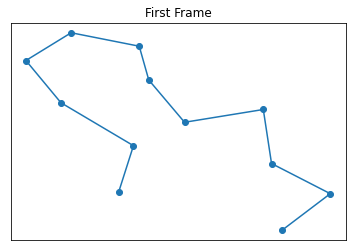

In [9]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/paths.npz", "paths.npz"
)
paths = np.load("paths.npz")["arr"]
# plot the first point
plt.title("First Frame")
plt.plot(paths[0, :, 0], paths[0, :, 1], "o-")
plt.xticks([])
plt.yticks([])
plt.show()

## Additional Installations and Imports

The following cells set up some additional installations we need. These may take some time. 

In [ ]:
pip install torch torchvision

In [ ]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+${111}.html

In [ ]:
pip install torch-cluster

In [ ]:
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+${CUDA}.html

In [ ]:
pip install torch-geometric

In [ ]:
pip install e3nn

In [7]:
#additional imports
import torch_geometric
from torch_geometric.data import Data, Dataset, DataLoader
import torch
import e3nn
import math
from e3nn.nn.models.gate_points_2101 import Network
from e3nn import o3

## Baseline Model

Before we build our E3NN network, it's always a good idea to build a baseline model for comparision. 

In [10]:
def mse(y, yhat):
  return (np.mean((yhat - y)**2))

First, let's discuss what the input and output should be for this model. The input should be the coordinates of the 12 points: one frame. What should the output be? We want to train a neural network to predict the next trajectory for each point, the next frame, so our output should actually be the same type as our input.

Thus,

**Inputs:**
* 12 sets of coordinates

**Outputs:**
* 12 sets of coordinates

Note: since we are trying to build an O(3)-equivariant neural network, which should be equivariant to transformations in 3D space, we need to make these coordinates 3D. This is easy, we will just put zero for the z-coordiantes. We'll do this now.

In [11]:
traj_3d = np.array([])
for i in range(2048):
    for j in range(12):
        TBA = paths[i][j]
        TBA = np.append(TBA, np.array([0.00,]))
        traj_3d = np.append(traj_3d, TBA)

traj_3d = traj_3d.reshape(2048,12,3)

Interestingly, for this example, we want our prediction from one frame to match the following frame. So our features and labels will be nearly identical, offset by one.

For the features, we want to include everything except for the final frame, which has no "next frame" in our data. We can extrapolate with our model to predict this "next frame" as a final step if we want. 

For our lables, we want to include everything except for the first step, which is not the "next frame" of anything in our data. 

We can also go ahead and split our data into training and testing sets. 

Let's do approximately an 80:20 split here.
We want to make sure not to shuffle our data, as we are predicting time-series data.

In [12]:
features = traj_3d[:-1]
labels = traj_3d[1:]

#split data 80:20
training_set = features[:1637]
training_labels = labels[:1637]
valid_set = features[1637:]
valid_labels = labels[1637:]

#convert to jnp arrays
training_setbl = jnp.asarray(training_set)
training_labelsbl = jnp.asarray(training_labels)

valid_setbl = jnp.asarray(valid_set)
valid_labelsbl= jnp.asarray(valid_labels)

Let's check to make sure our data matches up. Frame 2 in the features set should be the same as Frame 1 in the labels set.

In [13]:
print ("features, frame 2: \n", features[1])
print ("labels, frame 1: \n", labels[0])
if mse(features[1], labels[0]) == 0:
  print ("success! they match!")
else: 
  print (mse(features[1], labels[0]))

features, frame 2: 
 [[26.025177    6.05798388  0.        ]
 [26.11893272  6.39596176  0.        ]
 [25.65973854  6.70887423  0.        ]
 [25.43806076  7.01624107  0.        ]
 [25.72443008  7.21862507  0.        ]
 [26.15545464  7.12054539  0.        ]
 [26.21587372  6.8746376   0.        ]
 [26.44245338  6.56649923  0.        ]
 [26.94106674  6.65956831  0.        ]
 [26.99314117  6.26608562  0.        ]
 [27.36512375  6.04643583  0.        ]
 [27.05812454  5.77885437  0.        ]]
labels, frame 1: 
 [[26.025177    6.05798388  0.        ]
 [26.11893272  6.39596176  0.        ]
 [25.65973854  6.70887423  0.        ]
 [25.43806076  7.01624107  0.        ]
 [25.72443008  7.21862507  0.        ]
 [26.15545464  7.12054539  0.        ]
 [26.21587372  6.8746376   0.        ]
 [26.44245338  6.56649923  0.        ]
 [26.94106674  6.65956831  0.        ]
 [26.99314117  6.26608562  0.        ]
 [27.36512375  6.04643583  0.        ]
 [27.05812454  5.77885437  0.        ]]
success! they match!


Great, they match! Now we are ready to build our baseline model!


In [14]:
@jax.jit
def baseline_model(inputs, w, b):
    yhat = inputs @ w + b
    return yhat


def baseline_loss(inputs, y, w, b):
  return mse(y, baseline_model(inputs,w,b))

bl_loss_grad = jax.grad(baseline_loss, (2,3))

w = np.zeros((3,3))
w = jnp.asarray(w)
b = 0.0

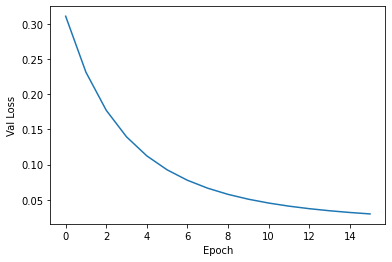

In [15]:
epochs = 16
eta = 1e-3

baseline_val_loss = [0.0 for _ in range(epochs)]

for epoch in range(epochs):
    for d in range(1637):
        inputs = training_setbl[d]
        y = training_labelsbl[d]
        grad_bl = bl_loss_grad(inputs, y, w, b)
        #update w & b
        w -= eta * grad_bl[0]
        b -= eta * grad_bl[1]

    for i in range(410):
        inputs_v = valid_setbl[i]
        y_v = valid_labelsbl[i]
        baseline_val_loss[epoch] += baseline_loss(inputs_v, y_v, w, b)
    baseline_val_loss[epoch] = jnp.sqrt(baseline_val_loss[epoch]/410)
    eta *= 0.9


plt.plot(baseline_val_loss)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.show()

Now let's view a parity plot to see if we're learning the right trend here.

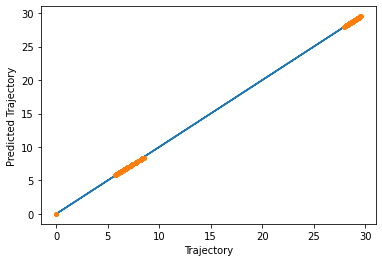

In [16]:
ys = jnp.array([])
yhats = jnp.array([])

for i in range(205):
    inputs_v = valid_setbl[i]
    ys = jnp.append(ys, valid_labelsbl[i])
    yhat = baseline_model(inputs_v,w,b)
    yhats = jnp.append(yhats, yhat)

plt.plot(ys, ys, "-")
plt.plot(ys, yhats, ".")
plt.xlabel("Trajectory")
plt.ylabel("Predicted Trajectory")
plt.show()

This is difficult to read, since our xyz coordinates are very different in magnitude. Instead, let's look at three plots, one for each coordinate. 

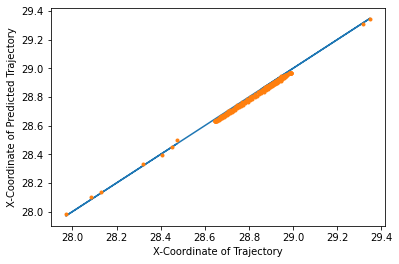

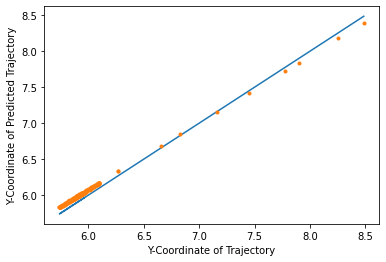

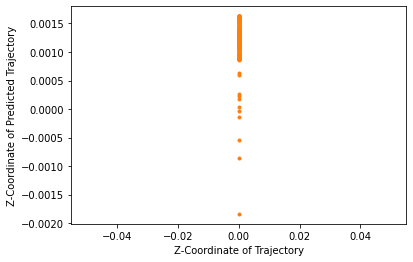

In [17]:
ys_x = jnp.array([])
ys_y = jnp.array([])
ys_z = jnp.array([])
yh_x = jnp.array([])
yh_y = jnp.array([])
yh_z = jnp.array([])

for i in range(205):
    inputs_v = valid_setbl[i]
    y = valid_labelsbl[i]
    yhat = baseline_model(inputs_v, w,b)
    
    ys_x = jnp.append(ys_x, y[i][0])
    ys_y = jnp.append(ys_y, y[i][1])
    ys_z = jnp.append(ys_z, y[i][2])
    
    yh_x = jnp.append(yh_x, yhat[i][0])
    yh_y = jnp.append(yh_y, yhat[i][1])
    yh_z = jnp.append(yh_z, yhat[i][2])

plt.plot(ys_x, ys_x, "-")
plt.plot(ys_x, yh_x, ".")
plt.xlabel("X-Coordinate of Trajectory")
plt.ylabel("X-Coordinate of Predicted Trajectory")
plt.show()

plt.plot(ys_y, ys_y, "-")
plt.plot(ys_y, yh_y, ".")
plt.xlabel("Y-Coordinate of Trajectory")
plt.ylabel("Y-Coordinate of Predicted Trajectory")
plt.show()

plt.plot(ys_z, ys_z, "-")
plt.plot(ys_z, yh_z, ".")
plt.xlabel("Z-Coordinate of Trajectory")
plt.ylabel("Z-Coordinate of Predicted Trajectory")
plt.show()

It looks like we're starting to get the right trend! However, as stated, we want any model that uses this data to be equivariant in 3D space. Let's check the equivariances now.

In [18]:
#checking for rotation equivariance
import scipy.spatial.transform as trans

#rotate around x coordinate by 80 degrees
rot = trans.Rotation.from_euler("x", 80, degrees=True)

input_point = jnp.asarray(np.random.normal(size=(12,3)))
w_test1 = jnp.asarray(np.random.normal(size=(3,3)))

input_rot = rot.apply(input_point)
output_1 = baseline_model(input_rot, w_test1, b)
output_prerot = baseline_model(input_point, w_test1, b)
output_rot = []
for xyz in output_prerot:
  coord = rot.apply(xyz)
  output_rot.append(coord)
output_rot = jnp.array(output_rot)

print ("rotated first: \n", output_1)
print ("rotated last: \n", output_rot)
print ("\033[1m" + "difference: " + "\033[0m", mse(output_1, output_rot))

rotated first: 
 [[ 5.0251517   2.7813923   0.29920053]
 [ 0.63903624  3.6262     -2.5190804 ]
 [-2.1388927   0.38203487 -3.3772705 ]
 [-0.26772738 -1.7997451   2.8343687 ]
 [-4.0527725  -0.82326746  0.31098452]
 [ 3.6362271  -1.6708347  -0.5624304 ]
 [-5.9493113  -0.7663736  -2.4192343 ]
 [ 5.1060705   1.4037013   1.5248324 ]
 [-2.073011   -3.2542696  -0.2813585 ]
 [ 0.82716596  2.7834308   0.47471258]
 [ 3.688524    4.507123    5.9960957 ]
 [ 0.2968478   0.49306753 -3.805884  ]]
rotated last: 
 [[-7.8030533e-01  1.0609260e+00  2.6283855e+00]
 [-6.4160986e+00 -8.4635687e-01  2.0598526e+00]
 [-5.7969499e+00 -3.3940261e-03 -1.0016966e+00]
 [ 5.6260061e+00 -3.0706927e-01 -4.7199702e-01]
 [ 4.4128737e-01 -2.0731218e+00 -7.9641318e-01]
 [ 9.3761075e-01  3.5382442e+00 -1.3177998e+00]
 [-4.0889173e+00 -1.9979175e+00 -1.8155043e+00]
 [ 2.1214354e+00  1.4478080e+00  1.9576374e+00]
 [ 1.6252856e+00  9.9255562e-01 -2.8293657e+00]
 [-1.1763276e+00 -1.5614860e+00  2.4394188e+00]
 [ 6.4850540e+00 -

So it doesn't look like our baseline model is rotation-equivariant. This is important, because we if we give our model coordinates that are rotated, we expect the output should be rotated by the same degree. Likewise, we need translation equivariance. Let's check that now.

In [19]:
#checking for translation equivariance
random_trans = jnp.asarray(np.random.normal(size=(12,3)))

input_trans = input_point + random_trans
output_2 = baseline_model(input_trans, w_test1, b)
output_trans = random_trans + baseline_model(input_point, w_test1, b)

print ("translated first: ", output_2)
print ("translated last: ", output_trans)
print ("\033[1m" + "difference: " + "\033[0m", mse(output_2, output_trans))

translated first:  [[ 2.7451873e+00 -1.8572230e-02 -1.3496170e+00]
 [-8.1664820e+00  2.3945546e+00  1.3892057e+00]
 [-6.0934772e+00 -1.9361558e+00 -2.1849427e+00]
 [ 4.0391836e+00  2.1432754e-01  8.2267731e-01]
 [-5.5254955e+00 -2.8945928e+00 -3.1790211e+00]
 [ 2.7370834e+00  2.2255595e+00 -1.3148420e+00]
 [-2.2978559e+00 -5.3900213e+00  4.8541136e+00]
 [ 7.8983107e+00  2.1562774e+00 -7.7389872e-01]
 [ 3.9651284e+00 -1.9591706e+00 -3.6098623e+00]
 [ 3.2247267e+00  4.0120797e+00  7.0996065e+00]
 [ 3.8329530e+00  6.9298263e+00  4.4144797e+00]
 [-5.0462136e+00  1.7369661e+00 -3.1356178e-03]]
translated last:  [[-2.1955729   1.1449147  -1.1963181 ]
 [-6.1197376   2.5304816   1.2635794 ]
 [-6.5166807  -1.1317943   0.36203322]
 [ 6.0768194   0.13205928  0.19751844]
 [-0.9670224   0.24906111  3.406692  ]
 [ 2.529489   -0.6556713  -3.7028525 ]
 [-5.0408444  -3.1551719  -0.85381234]
 [ 2.0181108   0.36469042 -1.1543138 ]
 [ 1.5155025  -3.3137982  -0.28292644]
 [ 0.33587432  1.2564595   0.459621

As expected, our model isn't translation equviariant either. I won't prove that we don't have parity/inversion equivariance, but you should expect that this baseline model will not have any spatial equivariance. 

We can solve this problem many ways. One way is to augment our data in order to teach our model equivariance. This requires more training and data storage, so let's look at a more compact approach.

## E3NN Basics

E3NN is a library for creating equivariant neural networks, specifically in E(3). E3NN is built for spatial equvariance in 3-D space. Specifically, this library gives us equivariance with respect to the E(3) group of rotations, inversions, and translations. As discussed before, the time-dependent trajectory's points do not change order, so we do not need to worry about permutation equivariance/invariance in this case; we only need E(3)-equivariance. E3NN is a great tool for this problem because we have 3-dimensional points in space, and if we transform them in space, we want the output to transform the same way.

E3NN works through the use of irreducible representations (irreps). In general, representations tell you how to interact with the data with repect to the group. When creating a model, we give the model the irreps so that it knows how to handle the data we will give it during trianing. It's not necessary to understand what the irreps are; instead, just know that they are the smallest representations, which are similar to, and transform the same way as, the spherical harmonics. Any (reducible) representation can be decomposed into irreducible representations. If you want to know more, you can check out more on the E3NN documentation website [@e3nn]. Let's take a look at how the irreps are used in this context. 

For this group, we need to find the L and d for each piece of data, where $d = 2L + 1$ (d = dimension). Look at the table below. 

| **parity** | **L** | **d** | **name**      |
|------------|-------|-------|---------------|
| even       | 0     | 1     | scalar        |
| odd        | 0     | 1     | pseudo scalar |
| even       | 1     | 3     | pseudo vector |
| odd        | 1     | 3     | vector        |
| even       | 2     | 5     |       -       |
| odd        | 2     | 5     |       -       |
|            |       |       |               |

The general notation is **MxLp**, where M is the number, L is the L from the table above, and p corresponds to the parity (e: even, o: odd). 

For example, if you wanted to portray "12 scalars, 4 vectors" in this format, you would write **"12x0e + 4x1o"**. Take a minute to make sure you understand how to use this notation, as it's essential for E3NN. E3NN deals with equivariance by receiving the irreps as a model parameter. This allows the E3NN framework to know how each input feature/output transforms under symmetry, so that it can treat each piece appropriately. As a side note, the output of an E3NN model must always be of equal or higher symmetry than your input.

Because E3NN is built to handle 3D spatial data, we do not need to tell the model that we are going to give it 3D coordinates; it's implicit and **required**. The irreps_in, instead, correspond to the input node features. In this example, we don't have input features, but as an example, you can imagine we could want our model to predict the next set of coordinates, given the intitial coordinates and the velocity. In that case, our irreps_in would be the velocity. If we gave our velocity as vectors, we would have **"12x1o""** as our input features. If we just gave our model the magnitude of the velocity, we would represent our input features as **"12x0e"**. 

Since we don't have input features, we'll put "None" for that parameter, and we want our output to be the same shape as the input: 12 vectors. However, since we are trying to predict 12 vectors out for 12 vectors in, we only need to tell the model to predict 1 vector per input **"1x1o"**. Take a minute to make sure you understand why this is the case. In this case, you can think of the model recognizing 12 input vectors and predicting a vector for each. Again, E3NN expects coordinate inputs, so we don't specify this for the input.

## E3NN Model

E3NN has several models within their library, which can be found [on the E3NN github page here](https://github.com/e3nn/e3nn/tree/main/e3nn/nn/models). For this example, we will use one of these models. 

To use the E3NN model, we need to turn our data into a torch_geometric dataset. We'll do that now. Then we can split our data into training and testing sets.

Also, instead of directly computing the next frame, we'll change it here to predict the distance to the next frame. This is a small change, but having data centered nearer zero is better for training.

In [20]:
feat = torch.from_numpy(features) #convert to pytorch tensors
ys = torch.from_numpy(labels) #convert to pytorch tensors
traj_data = []
distances = ys - feat #compute distances to next frame


#make torch_geometric dataset
#we want this to be an interable list
#x = None because we have no input features
for frame, label in zip(feat, distances):
  traj_data += [torch_geometric.data.Data(x = None, pos = frame.to(torch.float32), y = label.to(torch.float32))] 

train_split = 1637
train_loader = torch_geometric.data.DataLoader(traj_data[:train_split], batch_size=1, shuffle=False)

test_split = 1842
test_loader = torch_geometric.data.DataLoader(traj_data[train_split:test_split], batch_size=1, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Great! Now we're ready to define our model. Since this is a pre-built model in E3NN, so we just need to import it and define the model parameters. Note that the state of this model will save automatically, so you will need to reinitialize the model every time you want to start training. 

In [25]:
from e3nn.nn.models.gate_points_2101 import Network
from e3nn import o3

model_kwargs = {
    "irreps_in": None, #no input features
    "irreps_hidden": o3.Irreps("5x0e + 5x0o + 5x1e + 5x1o"), #hyperparameter
    "irreps_out": "1x1o", #12 vectors out, but only 1 vector out per input
    "irreps_node_attr": None, 
    "irreps_edge_attr": o3.Irreps.spherical_harmonics(3), 
    "layers": 3, #hyperparameter
    "max_radius": 3.5,
    "number_of_basis": 10,
    "radial_layers": 1,
    "radial_neurons": 128,
    "num_neighbors": 11, #average number of neighbors w/in max_radius
    "num_nodes": 12, #not important unless reduce_output is True
    "reduce_output": False, #setting this to true would give us one scalar as an output.
}

model = Network(**model_kwargs) #initializing model with parameters above

In [26]:
import torch.optim as optim

#this will print an outline of the model architecture!
eta = 1e-9
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
optimizer.zero_grad()
model.to('cuda')

Network(
  (layers): ModuleList(
    (0): Compose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(1x0e x 1x0e -> 10x0e+5x1o | 10 paths | 10 weights)
        (lin1): FullyConnectedTensorProduct(1x0e x 1x0e -> 1x0e | 1 paths | 1 weights)
        (fc): FullyConnectedNet[10, 128, 2]
        (tp): TensorProduct(1x0e x 1x0e+1x1o+1x2e+1x3o -> 1x0e+1x1o | 2 paths | 2 weights)
        (lin2): FullyConnectedTensorProduct(1x0e+1x1o x 1x0e -> 10x0e+5x1o | 15 paths | 15 weights)
      )
      (second): Gate (10x0e+5x1o -> 5x0e+5x1o)
    )
    (1): Compose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(5x0e+5x1o x 1x0e -> 15x0e+5x1o+5x1e | 100 paths | 100 weights)
        (lin1): FullyConnectedTensorProduct(5x0e+5x1o x 1x0e -> 5x0e+5x1o | 50 paths | 50 weights)
        (fc): FullyConnectedNet[10, 128, 30]
        (tp): TensorProduct(5x0e+5x1o x 1x0e+1x1o+1x2e+1x3o -> 10x0e+15x1o+5x1e | 30 paths | 30 weights)
        (lin2): FullyConnectedTensorProduct(1

In [27]:
epochs = 16

val_loss = [0.0 for _ in range(epochs)]
tr_loss = [0.0 for _ in range(epochs)]
count = 0

for epoch in range(epochs):
    count +=1
    for step, data in enumerate(train_loader):
      yhat = model(data.to('cuda'))
      loss_1 = torch.mean((yhat - data.y)**2)
      tr_loss[epoch] += (loss_1).detach()
      loss_1.backward()

      optimizer.step()
      optimizer.zero_grad()
    tr_loss[epoch] = tr_loss[epoch]/1637

    with torch.no_grad():
      for step, data in enumerate(test_loader):
        yhat = model(data.to('cuda'))
        loss2 = torch.mean((yhat - data.y)**2)
        val_loss[epoch] += (loss2).detach()
    val_loss[epoch] = val_loss[epoch]/205

    
    print ("epoch: ", count)
    print ("validation loss: ", val_loss[epoch])
    print ("training loss: ", tr_loss[epoch])
    print ()
    print ()


epoch:  1
validation loss:  tensor(3.5497, device='cuda:0')
training loss:  tensor(5.0360, device='cuda:0')


epoch:  2
validation loss:  tensor(3.5497, device='cuda:0')
training loss:  tensor(5.0360, device='cuda:0')


epoch:  3
validation loss:  tensor(3.5497, device='cuda:0')
training loss:  tensor(5.0360, device='cuda:0')


epoch:  4
validation loss:  tensor(3.5497, device='cuda:0')
training loss:  tensor(5.0359, device='cuda:0')


epoch:  5
validation loss:  tensor(3.5496, device='cuda:0')
training loss:  tensor(5.0359, device='cuda:0')


epoch:  6
validation loss:  tensor(3.5496, device='cuda:0')
training loss:  tensor(5.0359, device='cuda:0')


epoch:  7
validation loss:  tensor(3.5496, device='cuda:0')
training loss:  tensor(5.0358, device='cuda:0')


epoch:  8
validation loss:  tensor(3.5496, device='cuda:0')
training loss:  tensor(5.0358, device='cuda:0')


epoch:  9
validation loss:  tensor(3.5495, device='cuda:0')
training loss:  tensor(5.0358, device='cuda:0')


epoch:  10

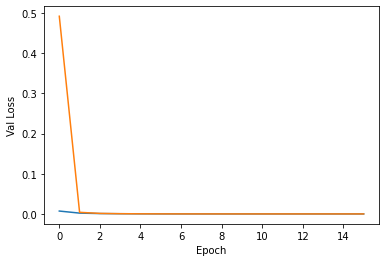

In [24]:
v_loss = torch.tensor(val_loss, device = 'cpu')
t_loss = torch.tensor(tr_loss, device = 'cpu')

plt.plot(v_loss)
plt.plot(t_loss)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.show()

Remember that we trained our model to predict the displacement. We can convert back by just adding our dispacement vectors back to their previous frame. We won't do it here, but we could do it to extrapolate our E3NN model to predict the next frame *not* included in the dataset. For now, we have a reasonably well trained model, and we could finish by testing our model for equivariance using the method described [here](https://docs.e3nn.org/en/stable/guide/equivar_testing.html).